# Load all required libraries

In [53]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install opencv-python
import cv2
import pandas as pd

In [52]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape
import tensorflow as tf

# Load our grayscale and (L)AB images from files

In [40]:
images_gray = np.load('./l/gray_scale.npy')
images_lab = np.load('./ab/ab/ab1.npy')

# Check counts of images in each dataset, for confirmation

In [18]:
len(images_gray)

25000

In [96]:
len(images_lab)

10000

# Verify, based on shape, that grayscale images and (L)AB images have expected layers in them

In [106]:
images_gray[0].shape

(224, 224)

In [107]:
images_lab[0].shape

(224, 224, 2)

# Make a function to grab the grayscale, A and B components of our overall LAB image

- This function also converts the aggregated (complete) LAB image into a RGB format prior to returning

In [47]:
def create_color_image_from_lab_grayscale(img_gray, img_lab):
    # import required packages
    import cv2
    import numpy as np
    
    # create a basic numpy array to contain our disaggregated image
    img = np.zeros((224, 224, 3))
    
    # add our grayscale part to layer one ('L')
    img[:, :, 0] = img_gray
    
    # add the two ('A' and 'B') layers from lab on top of the grayscale level one to get the "complete function"
    img[:, :, 1:] = img_lab
    img = img.astype('uint8')
    img_ = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img_

# Test out the grayscale image

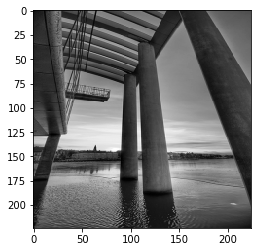

In [50]:
plt.imshow(images_gray[5], cmap="gray")

# Colorized image

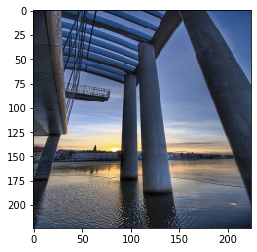

In [49]:
img_complete = create_color_image_from_lab_grayscale(images_gray[5],images_lab[5])
plt.imshow(img_complete)

In [74]:
# define another function to generate a batch of images instead of just one image for our use
def get_rbg_from_lab(gray_imgs, ab_imgs, n = 10):
    
    imgs = np.zeros((n, 224, 224, 3))
    imgs[:, :, :, 0] = gray_imgs[0:n:]
    imgs[:, :, :, 1:] = ab_imgs[0:n:]
    
    imgs = imgs.astype("uint8")
    
    imgs_ = []
    for i in range(0, n):
        imgs_.append(cv2.cvtColor(imgs[i], cv2.COLOR_LAB2RGB))

    imgs_ = np.array(imgs_)

    print(imgs_.shape)
    
    return imgs_

# Try out a model for experimentation

In [54]:
# import our weights for the Resnet v2 model from disk & load the model
modelv2 = InceptionResNetV2(input_shape = (224, 224, 3), 
                            weights = "./inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5")

In [57]:
# create an instance of model based on weights
new_model = Model(inputs = modelv2.inputs, outputs = modelv2.output)

In [58]:
# freeze the weights of all layers, so that they don't change down the line
for i, layer in enumerate(new_model.layers):
    layer.trainable = False

In [99]:
# check the trainable status of the individual layers
for layer in modelv2.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x16defe2d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x15fcfb2d0> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x18c5a5690> False
<tensorflow.python.keras.layers.core.Activation object at 0x15fd8a250> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x15fc50590> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x16dea4350> False
<tensorflow.python.keras.layers.core.Activation object at 0x18c94b490> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x18c951390> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x18c979d50> False
<tensorflow.python.keras.layers.core.Activation object at 0x18c979e90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x18c97fad0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x18c9a18d0>

<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1f4c8be10> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1f504ba90> False
<tensorflow.python.keras.layers.core.Activation object at 0x1f4c90790> False
<tensorflow.python.keras.layers.core.Activation object at 0x1f5054650> False
<tensorflow.python.keras.layers.merge.Concatenate object at 0x1f5059f90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1f5059210> False
<tensorflow.python.keras.layers.core.Lambda object at 0x1f51e4c90> False
<tensorflow.python.keras.layers.core.Activation object at 0x1f51e4d50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1f51f4110> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1f554e810> False
<tensorflow.python.keras.layers.core.Activation object at 0x1f5556890> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1f55569d0> False
<tensorflow.

In [59]:
# throw in additional layers for training
x = Reshape((5, 5, 40))(new_model.output)

x = Conv2DTranspose(strides = 2, kernel_size = 5, filters = 40, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , 
                    padding = "valid", activation = tf.nn.relu)(x)
x = Conv2DTranspose(strides = 3, kernel_size = 7, filters = 40, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , 
                    padding = "same", activation = tf.nn.relu)(x)
x = Conv2DTranspose(strides = 3, kernel_size = 9, filters = 20, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , 
                    padding = "same", activation = tf.nn.relu)(x)
x = Conv2DTranspose(strides = 4, kernel_size = 11, filters = 20, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , 
                    padding = "same", activation = tf.nn.relu)(x)
x = Conv2D(strides = 2, kernel_size = 5, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), 
           padding = "valid", activation = tf.nn.relu)(x)
x = Conv2D(strides = 1, kernel_size = 9, filters = 3, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05), 
           padding = "valid", activation = tf.nn.relu)(x)


final_model = Model(inputs = new_model.inputs, outputs = x)

In [63]:
# configure the model for training
final_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
                    loss = tf.compat.v1.losses.mean_pairwise_squared_error)

In [64]:
# define additional func for pipelining image aggregation from grayscale (L) + AB = LAB -> RGB
def pipe_line_img(gray_scale_imgs, batch_size = 100, preprocess_f = preprocess_input):
    imgs = np.zeros((batch_size, 224, 224, 3))
    for i in range(0, 3):
        imgs[:batch_size, :, :,i] = gray_scale_imgs[:batch_size]
    return preprocess_f(imgs)

In [65]:
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./folder_to_save_graph_3', 
                                            histogram_freq=0, 
                                            write_graph=True, 
                                            write_images=True)

In [66]:
imgs_for_input = pipe_line_img(images_gray, batch_size = 300)

In [75]:
imgs_for_output = preprocess_input(get_rbg_from_lab(gray_imgs = images_gray, ab_imgs = images_lab, n = 300))

(300, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


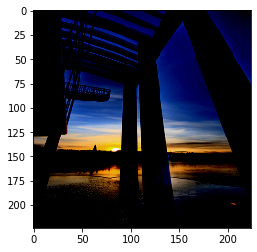

In [76]:
plt.imshow(imgs_for_output[5])

In [77]:
final_model.fit(imgs_for_input, imgs_for_output, epochs = 5, batch_size = 30, callbacks = [tbCallBack])

Train on 300 samples
Epoch 1/5
300/300 [==============================] - 120s 401ms/sample - loss: 14.2525
Epoch 2/5
300/300 [==============================] - 125s 418ms/sample - loss: 14.2327
Epoch 3/5
300/300 [==============================] - 130s 433ms/sample - loss: 14.2168
Epoch 4/5
300/300 [==============================] - 112s 375ms/sample - loss: 14.2231
Epoch 5/5
300/300 [==============================] - 111s 371ms/sample - loss: 14.2205


In [91]:
prediction2 = final_model.predict(x = pipe_line_img(gray_scale_imgs = images_gray, batch_size = 300))

In [98]:
prediction2.shape

(300, 224, 224, 3)

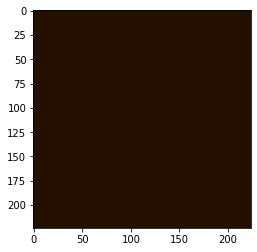

In [104]:
plt.imshow(prediction2[299])